# Goal

Predict inclusion and exclusion of abstracts for Ceres2030 Team 6.

This document compares three natural language processing (NLP) approaches to binary classification:
- BERT
- Naive Bayes
- Support Vector Machines (SVM)

We find each method is better than or present inter-rater reliability of 82%. Inter-rater reliability is a measure of the percent of conflicts reviewers had compared total abstracts double reviewed.

Here is a summary of our findings.

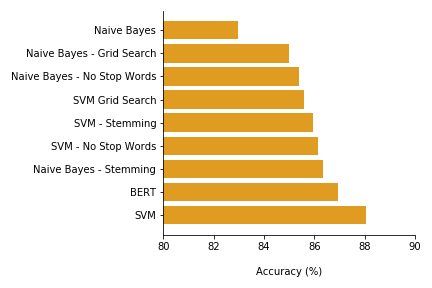

In [190]:
from IPython.display import Image
Image(filename='compare_model.png',width=400)

# Load data

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [37]:
selected = pd.read_csv('./data/review_59500_select_csv_20190627214526.csv')
irrelevant = pd.read_csv('./data/review_59500_irrelevant_csv_20190627214450.csv')

#### Clean up dataframe

In [38]:
# selected['text'] = selected['Title'] + ' ' + selected['Abstract']
selected['text'] = selected['Abstract'].str.replace('Abstract: ', '')
selected['text'] = selected['text'].str.split('#',  n = 1, expand = True)
selected['sentiment'] = 1

# irrelevant['text'] = irrelevant['Title'] + ' ' + irrelevant['Abstract']
irrelevant['text'] = irrelevant['Abstract'].str.replace('Abstract: ', '')
irrelevant['text'] = irrelevant['text'].str.split('#',  n = 1, expand = True)
irrelevant['sentiment'] = 0

df = pd.concat([
    selected.loc[:, ['text', 'sentiment']],
    irrelevant.loc[:, ['text', 'sentiment']],
])

df.describe()

,sentiment
count,703.000000
mean,0.159317
std,0.366232
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


#### Split into training and testing datasets.

In [39]:
train, test = train_test_split(df)
train = train.sample(len(train))
t = pd.concat([train.describe(), test.describe()], axis = 1)
t.columns = ['train', 'test']
t

,train,test
count,527.000000,176.000000
mean,0.155598,0.170455
std,0.362818,0.377104
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


# BERT

## A high-level approach

Base code heavily borrowed from [this Google Colab Notebook](https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb).

Please refer to [this Medium Article](https://medium.com/@wshuyi/how-to-do-text-binary-classification-with-bert-f1348a25d905) for detailed information.



In [40]:
from bert_text import run_on_dfs
import warnings
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.FATAL)

In [41]:
myparam = {
    'DATA_COLUMN': 'text',
    'LABEL_COLUMN': 'sentiment',
    'LEARNING_RATE': 2e-5,
    'MAX_SEQ_LENGTH': 512,
    'NUM_TRAIN_EPOCHS': 10,
    'bert_model_hub': 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
}

In [42]:
warnings.filterwarnings('ignore')
result, estimator = run_on_dfs(train, test, **myparam)

In [58]:
bert_1 = result
bert_1

{'auc': 0.6828767,
 'eval_accuracy': 0.8693182,
 'f1_score': 0.9245901,
 'false_negatives': 5.0,
 'false_positives': 18.0,
 'loss': 0.85573626,
 'precision': 0.8867925,
 'recall': 0.96575344,
 'true_negatives': 12.0,
 'true_positives': 141.0,
 'global_step': 164}

## A more detailed approach

The following is essentially what the above was written on top of.

Base code for this section heavily borrowed/copied from [this Google Colab Notebook](https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb#scrollTo=fom_ff20gyy6).

In [44]:
# !pip install bert-tensorflow

In [45]:
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

### Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [46]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'sentiment'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

In [15]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [16]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

In [17]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [18]:
# We'll set sequences to be at most 512 tokens long.
MAX_SEQ_LENGTH = 512

# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(
    train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

test_features = bert.run_classifier.convert_examples_to_features(
    test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

### Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our sentiment task (i.e. classifying whether an abstract is included or exclude). This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

In [19]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for our data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    
    return (loss, predicted_labels, log_probs)

Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [20]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [21]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 10.
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [22]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [23]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
#     model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [24]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [25]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

### Train model

In [26]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Training took time  1:54:51.887693


### Test model

This result will be similar to the streamlined approach, but not identical because we didn't set a seed for the randomization.

In [27]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [168]:
bert_2 = estimator.evaluate(input_fn=test_input_fn, steps=None)
bert_2

### Predict

In [29]:
def getPrediction(in_sentences):
  labels = ['Exclude', 'Include']
  input_examples = [run_classifier.InputExample(guid='', text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [33]:
pred_sentences = [
"Emerging trends of a changing and increasingly variable climate have introduced new livelihood challenges in rain-fed smallholder agricultural systems that predominate in Sub-Saharan Africa (SSA). The capacity of local farming communities and their institutions to respond to the new and emerging impacts of climate change is often constrained by lack of access to information and improved technologies, as well as poor support mechanisms to promote assimilation of new knowledge. This threatens to heighten vulnerability of the majority of SSA's rural communities who are already facing severe problems of food insecurity and a declining soil resource base. In this paper we use two case studies from Wenchi district in Ghana and Makoni in Zimbabwe to communicate how participatory action research (PAR) methodology, characterised by iterative planning-action-reflection cycles, was coupled with a new concept of field-based farmer learning centres to build adaptive capacity of smallholder farmers to climate change. The study was part of a University of Zimbabwe-led project supported under the Climate Change Adaptation in Africa (CCAA) programme to explore the state of resilience in African smallholder farming. The PAR and learning centre processes enabled communities, local leaders, and extension agents and researchers to establish the, hither to, imperceptible link between poor soil fertility and rising institutional challenges within communities. Institutional conflicts related to land tenure and sharecropping arrangements between migrant farmers and native landowners were addressed in Ghana, while local institutions supporting traditional social safety net mechanisms were revitalized in Zimbabwe. In both cases, it was apparent that farmers faced multiple stresses, at the core of which were poor and declining soil fertility and weakening local institutions. The worsening rainfall distribution and increasing cases of drought are broadening the scope for vulnerability, often driving competing claims and conflicts. PAR was successfully used as an entry point, empowering communities to self-mobilize and self-organize to co-learn and experiment with integrated soil fertility management (ISFM) technologies and other improved farming practices. They realised opportunities for achieving high crop yields and generate surpluses in good years. Strengthening local institutional capacity to revitalise community safety nets proved an essential ingredient for enhancing adaptive capacity of smallholders to climatic shocks. The PAR process was a major driver of effective partnerships among community members, extension, policy makers and researchers, but ensuing success generated a new set of social challenges that could not be addressed within the short timescale of the project. We conclude that PAR was a suitable mechanism for supporting self-organization and co-learning processes among smallholder farmers and their service providers, enabling them to use ISFM technologies and strengthen their local institutions around natural resource management. This revealed the scope for building adaptive capacity of these communities against climate change and variability.",
"Farmers in Southern Africa are already experiencing changes to their climate that are different in magnitude to what they have experienced in the past. Some of these changes, particularly higher temperatures and greater rainfall intensity, are consistent with what scientists expect to happen as the Earth's climate warms due to emissions of carbon dioxide and other greenhouse gases. These changes are adding to other political, economic and environmental stresses on their livelihoods. This report comprises new field research by Oxfam and Kulima Integrated Development Solutions with over 200 farmers in five countries of Southern Africa. It finds considerable agreement between farmers across countries that they are observing changes in climate. The perceptions of farmers largely find backing in the meteorological data. Ongoing climate change, bringing increasing temperatures and further changes to precipitation patterns, is projected to make food production more difficult. Recent scientific research compiling the results of many thousands of field tests on maize, in particular, demonstrate the serious effects of temperature increases and changes in moisture (Lobell et al, 2011a). Climate change is likely to reduce yields and increase food prices, with serious effects on both farmers and consumers. Farmers are already actively experimenting and changing agricultural practices and pursuing ways to diversify livelihoods in light of both the new changes to their climate and other multiple stresses. In some cases, these changes can be considered actual or potential successes in adapting to climate change; in other cases they may be simply coping, and other strategies can be considered maladaptation, particularly where they create environmental degradation. Furthermore, whereas large-scale farmers, in the main, have access to the resources needed to adapt, small-scale farmers face major obstacles. These obstacles may not only prevent adaptation but also lead farmers into maladaptation, for want of other choices. Major new resources must be raised from domestic, regional and international levels to focus on and build the adaptive capacity of small-scale farmers and sustain levels of food production into the future.",
"In marginal areas, including saline lands, patchy plant stands often result from poor and uneven germination of the crop. The technique of 'on-farm' seed priming, where the seed is soaked in water, usually overnight, before being surface dried and then sown, has been shown to improve plant stands and provide benefits in terms of earlier maturity, reduced disease and increased yields in a range of crops in rainfed areas in Africa, India, Nepal and Bangladesh, as well as in irrigated crops grown on normal soils in India. This paper describes trials to assess the technique for maize, wheat and chickpea grown in saline lands in the North West Frontier Province of Pakistan, using a mixture of on-farm and farmer-participatory trials. Initial studies on germination carried out in laboratory conditions are also reported. In almost all the trials, priming had a significant positive effect on yields: the only trials in which it was not successful were those on dense saline-sodic soils, and possible reasons for this are discussed. Feedback from the farmers indicated that they had very favourable impressions of the technique.",
"This chapter focuses on the N contribution by promiscuous soyabean in an attempt to develop sustainable cropping systems in the moist savanna in West Africa. There is, however, a dearth of reliable estimates of N fixation by these promiscuous soyabean and hardly any quantitative information is available on their residual N benefits to subsequent cereal crops grown in the southern Guinea savanna (SGS) zone. The actual amount of N fixed by promiscuous soyabean varied between 38 and 126 kg N ha. Assuming that only seed of soyabean are removed from the plots, it is estimated that the net N accrual to soil ranges between -8 kg N ha and +47 kg N ha depending on the soyabean lines. Residual soyabean N values between 10 and 24 kg N ha representing 14 to 36% of the maize total N were obtained in maize grown after soyabean. Although traditionally the increases in cereal yield following legume cultivation are attributed to greater N accumulation, our data show that the relative increase in maize N following soyabean was smaller than the relative increase in dry matter yield. Hence, the increased yields of maize following soyabean were not due entirely to the carry-over of N from the soyabean residue and to the soil N-conserving effect but were also due to other effects called rotational effects. From the preceding quantitative considerations, it is clear that the biological nitrogen fixation (BNF) benefit of grain legumes to non-legumes due to their inclusion in a cropping system is small indeed compared to the level of N fertilizer use in the more intensive cereal production systems of the developed world but is significant at present in the context of the low input levels in subsistence farming in the tropics." 
]

In [34]:
predictions = getPrediction(pred_sentences)

In [179]:
[print(predictions[i][2]) for i in range(len(predictions))];

Exclude
Exclude
Exclude
Include


# Comparing BERT with other text classifications 

## Prep data for all models

The following code is borrowed from this [link](https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a).

Each algorithm employs a Bag of Words approach.

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

In [61]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.text)
# X_train_counts.shape

(527, 10887)

In [62]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_train_tfidf.shape

(527, 10887)

## Naive Bayes

Check out [here](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) for more detail.

In [63]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train.sentiment)

In [64]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

text_clf = text_clf.fit(train.text, train.sentiment)

In [67]:
import numpy as np
predicted = text_clf.predict(test.text)
nb_1 = np.mean(predicted == test.sentiment)
nb_1

0.8295454545454546

## Support Vector Machines (SVM)

Check out [here](https://scikit-learn.org/stable/modules/svm.html) for more detail.

In [69]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3, random_state=42)),
])

_ = text_clf_svm.fit(train.text, train.sentiment)

predicted_svm = text_clf_svm.predict(test.text)
svm_1 = np.mean(predicted_svm == test.sentiment) 
svm_1

0.8806818181818182

## Grid Search

Check out [here](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) for more detail.

### Grid search with Naive Bayes

In [72]:
from sklearn.model_selection import GridSearchCV

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train.text, train.sentiment)

nb_gs = gs_clf.best_score_
# gs_clf.best_params_
nb_gs

0.8500948766603416

### Grid search with SVM

In [74]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3),
}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(train.text, train.sentiment)

svm_gs = gs_clf_svm.best_score_
# gs_clf_svm.best_params_
svm_gs

0.855787476280835

## Further Tuning

### Remove stop words

Stop words, such as "the, then, etc." 

#### Naive Bayes

In [75]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train.text, train.sentiment)

nb_gs_rs = gs_clf.best_score_
# gs_clf.best_params_
nb_gs_rs

0.8538899430740038

#### SVM

In [78]:
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3,random_state=42)),
])

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3),
}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(train.text, train.sentiment)

svm_gs_rs = gs_clf_svm.best_score_
# gs_clf_svm.best_params_
svm_gs_rs

0.8614800759013282

### Stemming

Stemming extracts the root word, such as changing fishing to fish. The stemmer we're using works well for English, but might throw us off for non-English. In further tuning, we should separate the non-English studies (which are few in our case).

In [83]:
import nltk

# if you're running this for the first time, you need to download some files:
# nltk.download()

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english', ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

#### Naive Bayes

In [84]:
text_clf = Pipeline([('vect', StemmedCountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train.text, train.sentiment)

nb_gs_stem = gs_clf.best_score_
# gs_clf.best_params_
nb_gs_stem

0.8633776091081594

#### SVM

In [85]:
text_clf_svm = Pipeline([('vect', StemmedCountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3,random_state=42)),
])

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3),
}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(train.text, train.sentiment)

svm_gs_stem = gs_clf_svm.best_score_
# gs_clf_svm.best_params_
svm_gs_stem

0.8595825426944972

# Compare All Models

In [122]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [164]:
df = {
    'BERT': bert_1['eval_accuracy'],
    'Naive Bayes': nb_1,
    'SVM': svm_1,
    'Naive Bayes - Grid Search': nb_gs,
    'SVM Grid Search': svm_gs,
    'Naive Bayes - No Stop Words': nb_gs_rs,
    'SVM - No Stop Words': svm_gs_rs,
    'Naive Bayes - Stemming': nb_gs_stem,
    'SVM - Stemming': svm_gs_stem
}

df = pd.DataFrame(df.keys(), df.values()).reset_index()
df.columns = ['value', 'metric']
df = df.sort_values('value').reset_index()
df['value'] = df['value'] * 100

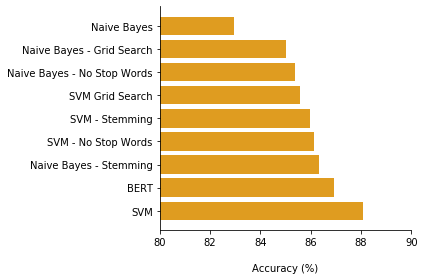

In [187]:
fig, ax = plt.subplots()
sns.barplot(x='value', y='metric', data=df, color='orange', ax=ax)
ax.set_xlim(80, 90)
ax.set_xlabel('\nAccuracy (%)')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.plot()
plt.tight_layout()
plt.savefig('compare_model.png')